This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# RADOLAN Radar Network

In this chapter the RW-product is shown in WGS84 and the RADOLAN [Polar Stereographic Projection](radolan_grid.ipynb#Polar-Stereographic-Projection). All for the compositing process used radars are extracted from the metadata and plotted with their respective maximum range rings and location information.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
from osgeo import osr

In [2]:
def get_radar_locations():
    radars = {}
    radar = {'name': 'ASR Dresden', 'wmo': 10487, 'lon': 13.76347,
             'lat': 51.12404, 'alt': 261}
    radars['ASD'] = radar

    radar = {'name': 'Boostedt', 'wmo': 10132, 'lon': 10.04687,
             'lat': 54.00438, 'alt': 124.56}
    radars['BOO'] = radar

    radar = {'name': 'Dresden', 'wmo': 10488, 'lon': 13.76865, 'lat': 51.12465,
             'alt': 263.36}
    radars['DRS'] = radar

    radar = {'name': 'Eisberg', 'wmo': 10780, 'lon': 12.40278, 'lat': 49.54066,
             'alt': 798.79}
    radars['EIS'] = radar

    radar = {'name': 'Emden', 'wmo': 10204, 'lon': 7.02377, 'lat': 53.33872,
             'alt': 58}
    radars['EMD'] = radar

    radar = {'name': 'Essen', 'wmo': 10410, 'lon': 6.96712, 'lat': 51.40563,
             'alt': 185.10}
    radars['ESS'] = radar

    radar = {'name': 'Feldberg', 'wmo': 10908, 'lon': 8.00361, 'lat': 47.87361,
             'alt': 1516.10}
    radars['FBG'] = radar

    radar = {'name': 'Flechtdorf', 'wmo': 10440, 'lon': 8.802, 'lat': 51.3112,
             'alt': 627.88}
    radars['FLD'] = radar

    radar = {'name': 'Hannover', 'wmo': 10339, 'lon': 9.69452, 'lat': 52.46008,
             'alt': 97.66}
    radars['HNR'] = radar

    radar = {'name': 'Neuhaus', 'wmo': 10557, 'lon': 11.13504, 'lat': 50.50012,
             'alt': 878.04}
    radars['NEU'] = radar

    radar = {'name': 'Neuheilenbach', 'wmo': 10605, 'lon': 6.54853,
             'lat': 50.10965, 'alt': 585.84}
    radars['NHB'] = radar

    radar = {'name': 'Offenthal', 'wmo': 10629, 'lon': 8.71293, 'lat': 49.9847,
             'alt': 245.80}
    radars['OFT'] = radar

    radar = {'name': 'Proetzel', 'wmo': 10392, 'lon': 13.85821,
             'lat': 52.64867, 'alt': 193.92}
    radars['PRO'] = radar

    radar = {'name': 'Memmingen', 'wmo': 10950, 'lon': 10.21924,
             'lat': 48.04214, 'alt': 724.40}
    radars['MEM'] = radar

    radar = {'name': 'Rostock', 'wmo': 10169, 'lon': 12.05808, 'lat': 54.17566,
             'alt': 37}
    radars['ROS'] = radar

    radar = {'name': 'Isen', 'wmo': 10873, 'lon': 12.10177, 'lat': 48.1747,
             'alt': 677.77}
    radars['ISN'] = radar

    radar = {'name': 'Tuerkheim', 'wmo': 10832, 'lon': 9.78278,
             'lat': 48.58528, 'alt': 767.62}
    radars['TUR'] = radar

    radar = {'name': 'Ummendorf', 'wmo': 10356, 'lon': 11.17609,
             'lat': 52.16009, 'alt': 183}
    radars['UMM'] = radar

    return radars

In [3]:
# load radolan file
rw_filename = wrl.util.get_wradlib_data_file('radolan/showcase/raa01-rw_10000-1408102050-dwd---bin.gz')
rwdata, rwattrs = wrl.io.read_radolan_composite(rw_filename)

In [4]:
# print the available attributes
print("RW Attributes:", rwattrs)

RW Attributes: {'producttype': 'RW', 'datetime': datetime.datetime(2014, 8, 10, 20, 50), 'radarid': '10000', 'datasize': 1620000, 'maxrange': '150 km', 'radolanversion': '2.13.1', 'precision': 0.1, 'intervalseconds': 3600, 'nrow': 900, 'ncol': 900, 'radarlocations': ['boo', 'ros', 'emd', 'hnr', 'umd', 'pro', 'ess', 'asd', 'neu', 'nhb', 'oft', 'tur', 'isn', 'fbg', 'mem'], 'nodataflag': -9999, 'secondary': array([   799,    800,    801, ..., 806263, 806264, 807163]), 'cluttermask': array([], dtype=int64)}


In [5]:
# mask data
sec = rwattrs['secondary']
rwdata.flat[sec] = -9999
rwdata = np.ma.masked_equal(rwdata, -9999)

# create radolan projection object
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# create wgs84 projection object
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

# get radolan grid
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900)
x1 = radolan_grid_xy[:, :, 0]
y1 = radolan_grid_xy[:, :, 1]

# convert to lonlat
radolan_grid_ll = wrl.georef.reproject(radolan_grid_xy,
                                       projection_source=proj_stereo,
                                       projection_target=proj_wgs)
lon1 = radolan_grid_ll[:, :, 0]
lat1 = radolan_grid_ll[:, :, 1]

In [6]:
# range array 150 km
print("Max Range: ", rwattrs['maxrange'])
r = np.arange(1, 151) * 1000
# azimuth array 1 degree spacing
az = np.linspace(0, 360, 361)[0:-1]

Max Range:  150 km


In [7]:
# get radar dict
radars = get_radar_locations()

In [8]:
def plot_radar(radar, ax, proj):
    
    site = (radar['lon'], radar['lat'], radar['alt'] )
    
    # build polygons for maxrange rangering
    polygons = wrl.georef.spherical_to_polyvert(r, az, 0,
                                                site, 
                                                proj=proj)
    polygons = polygons[..., 0:2]
    polygons.shape = (len(az), len(r), 5, 2)
    polygons = polygons[:, -1, :, :]
    
    x_loc, y_loc = wrl.georef.reproject(site[0], site[1],
                                        projection_source=proj_wgs,
                                        projection_target=proj)
        

    # create PolyCollections and add to respective axes
    polycoll = mpl.collections.PolyCollection(polygons, closed=True,
                                              edgecolors='r',
                                              facecolors='r')
    ax.add_collection(polycoll, autolim=True)
    
    # plot radar location and information text
    ax.plot(x_loc, y_loc, 'r+')
    ax.text(x_loc, y_loc, radar['name'], color='r')

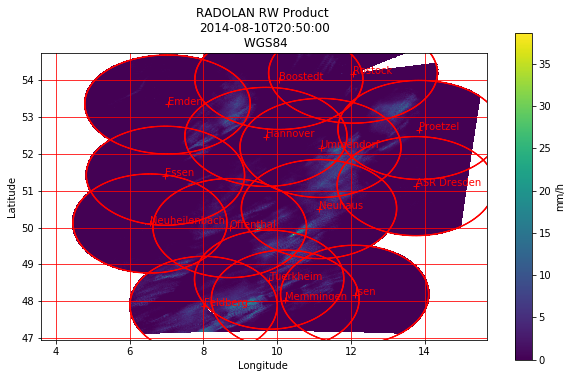

In [9]:
# plot two projections side by side
fig1 = pl.figure(figsize=(10,8))
ax1 = fig1.add_subplot(111, aspect='equal')
pm = ax1.pcolormesh(lon1, lat1, rwdata, cmap='viridis')
cb = fig1.colorbar(pm, shrink=0.75)
cb.set_label("mm/h")
pl.xlabel("Longitude ")
pl.ylabel("Latitude")
pl.title(
    'RADOLAN RW Product \n' + rwattrs['datetime'].isoformat() + '\n WGS84')
pl.xlim((lon1[0, 0], lon1[-1, -1]))
pl.ylim((lat1[0, 0], lat1[-1, -1]))
pl.grid(color='r')
for radar_id in rwattrs['radarlocations']:
    # get radar coords etc from dict
    # repair Ummendorf ID
    if radar_id == 'umd':
        radar_id = 'umm'
    radar = radars[radar_id.upper()]
    plot_radar(radar, ax1, proj_wgs)

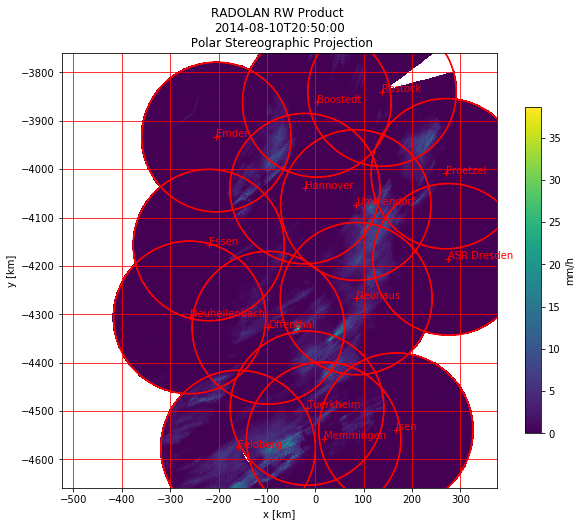

In [10]:
fig2 = pl.figure(figsize=(10,8))
ax2 = fig2.add_subplot(111, aspect='equal')
pm = ax2.pcolormesh(x1, y1, rwdata, cmap='viridis')
cb = fig2.colorbar(pm, shrink=0.75)
cb.set_label("mm/h")
pl.xlabel("x [km]")
pl.ylabel("y [km]")
pl.title('RADOLAN RW Product \n' + rwattrs[
    'datetime'].isoformat() + '\n Polar Stereographic Projection')
pl.xlim((x1[0, 0], x1[-1, -1]))
pl.ylim((y1[0, 0], y1[-1, -1]))
pl.grid(color='r')
for radar_id in rwattrs['radarlocations']:
    # get radar coords etc from dict
    # repair Ummendorf ID
    if radar_id == 'umd':
        radar_id = 'umm'
    radar = radars[radar_id.upper()]
    plot_radar(radar, ax2, proj_stereo)